## Installing needed libraries

In [208]:
pip install optuna lightgbm xgboost

Note: you may need to restart the kernel to use updated packages.


## EDA

In [273]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import numpy as np

from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score
import warnings
warnings.filterwarnings('ignore')

In [284]:
df = pd.read_csv('fin_no_leakage - Sheet1.csv')
df

,Credit ID,Customer ID,Loan Created Date,hist_notes,overdues_sum,overdues_max,overdues_mean,n_loan_types,last_end,Type Credit,Sex,Birthday
0,695553,843,2021-05-20,2,64.0,32.0,32.000000,1,2019-03-07,Normal,Man,1960-09-25
1,992484,1801,2021-07-02,1,32.0,32.0,32.000000,1,2019-09-03,Normal,Woman,1982-12-24
2,602834,694,2021-04-21,4,0.0,0.0,0.000000,2,2019-10-03,Normal,Woman,1952-12-07
3,272034,1755,2021-08-09,1,0.0,0.0,0.000000,1,2019-11-02,Normal,Man,1995-04-24
4,601804,318,2020-09-27,4,21.0,21.0,5.250000,2,2019-10-03,Normal,Woman,1960-03-14
...,...,...,...,...,...,...,...,...,...,...,...,...
567,368316,857,2021-10-15,6,79.0,79.0,13.166667,3,2019-12-02,Normal,Man,1993-01-22
568,797427,371,2022-03-06,3,50.0,24.0,16.666667,2,2021-08-24,Problem,Woman,1949-04-12
569,490044,1207,2020-03-30,0,NaN,NaN,NaN,0,NaN,Problem,Man,1955-08-29
570,698771,1357,2022-10-29,1,0.0,0.0,0.000000,1,2019-04-06,Normal,Woman,1991-06-01


In [285]:
df.isnull().sum()

Credit ID             0
Customer ID           0
Loan Created Date     0
hist_notes            0
overdues_sum          1
overdues_max          1
overdues_mean         1
n_loan_types          0
last_end              1
Type Credit           0
Sex                   0
Birthday             25
dtype: int64

In [308]:
df['last_end'].isnull()

0      False
1      False
2      False
3      False
4      False
       ...  
567    False
568    False
569     True
570    False
571    False
Name: last_end, Length: 572, dtype: bool

In [309]:
df = df.drop(569)  # dropping the problematic row

In [310]:
df['n_loan_types'].unique()

array([1, 2, 3])

In [311]:
# Смотрим нет ли дубликатов после объединения
double = df[df.duplicated(subset=["Customer ID", "Credit ID"])]
double

,Credit ID,Customer ID,Loan Created Date,hist_notes,overdues_sum,overdues_max,overdues_mean,n_loan_types,last_end,Type Credit,Sex,Birthday,loan_date,loan_end,Age,loan_days,loan_year,loan_months,gender,TARGET
56,76655,229,2021-07-11,2,0.0,0.0,0.0,2,2019-12-02,Problem,Man,1962-11-16,2021-07-11,2019-02-12,58.0,-880.0,2021,7,0.0,1.0
57,76655,1966,2020-01-06,1,13.0,13.0,13.0,1,2019-07-05,Problem,Man,1990-08-23,2020-01-06,2019-05-07,29.0,-244.0,2020,1,0.0,1.0
282,651171,49,2021-02-10,2,0.0,0.0,0.0,1,2019-08-04,Normal,Man,1978-05-03,2021-02-10,2019-04-08,42.0,-674.0,2021,2,0.0,0.0
283,651171,1738,2021-09-19,2,72.0,72.0,36.0,2,2019-11-02,Normal,Man,1956-03-25,2021-09-19,2019-02-11,65.0,-951.0,2021,9,0.0,0.0


In [316]:
df.isnull().sum() # Нужно делать что-то с 'Birthdays'

Credit ID             0
Customer ID           0
Loan Created Date     0
hist_notes            0
overdues_sum          0
overdues_max          0
overdues_mean         0
n_loan_types          0
last_end              0
Type Credit           0
Sex                   0
Birthday              0
loan_date             0
loan_end             43
Age                   0
loan_days            43
loan_year             0
loan_months           0
gender                0
TARGET                0
dtype: int64

In [315]:
df["Birthday"] = pd.to_datetime(df["Birthday"], errors="coerce") 
df["loan_date"] = pd.to_datetime(df["Loan Created Date"], dayfirst=True) 
df["loan_end"] = pd.to_datetime(df["last_end"], errors="coerce", dayfirst=True) 
df["Age"] = (df["loan_date"] - df["Birthday"]).dt.days // 365 #! дату рождения следовало вычитать из даты заявки или другой исторической даты имеющей какое-то значение на момент заявки (today сейчас сильно отличается от today на момент формирования заявки)

df['loan_days']= (df['loan_end']-df['loan_date']).dt.days

df["loan_year"] = df["loan_date"].dt.year 
df["loan_months"] = df["loan_date"].dt.month

df["gender"] = df["Sex"].map({"Woman": 1, "Man": 0}).astype('float64') 
df['TARGET'] = df['Type Credit'].map({'Problem':1, 'Normal':0}).astype('float64')

In [317]:
# Сохранила колонки, чтобы не терять данные. Подставила медиану вместо Nan.
brth_median = df['Birthday'].median()
df['Birthday']=df['Birthday'].fillna(brth_median)

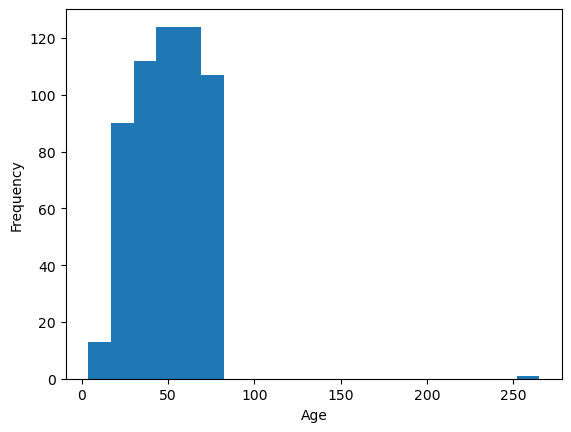

In [318]:
df['Age'].plot(kind='hist', bins=20)
plt.xlabel('Age')
#plt.xlim(50,150)
plt.show()

In [319]:
count_outlier = df[df['Age']<5].shape[0]
count_outliers = df[df['Age']>100].shape[0]
print(f'Extremely young customers: {count_outlier}, impossibly old customers: {count_outliers}')

Extremely young customers: 1, impossibly old customers: 1


In [320]:
df['Age'].astype(int)

0      60
1      38
2      68
3      26
4      60
       ..
566    29
567    28
568    72
570    31
571    67
Name: Age, Length: 571, dtype: int64

In [325]:
# df w/o Age outliers
df = df[(df['Age']>=5)  & (df['Age'] <100)]
df.isnull().sum()

Credit ID             0
Customer ID           0
Loan Created Date     0
hist_notes            0
overdues_sum          0
overdues_max          0
overdues_mean         0
n_loan_types          0
last_end              0
Type Credit           0
Sex                   0
Birthday              0
loan_date             0
loan_end             43
Age                   0
loan_days            43
loan_year             0
loan_months           0
gender                0
TARGET                0
dtype: int64

In [322]:
count300 = (df['loan_days']==300).shape[0]
count300

569

In [326]:
numerical_cols = ['hist_notes', 'overdues_sum', 'overdues_max', 'overdues_mean', 'n_loan_types	', 'Age', 'loan_year', 'loan_months', 'TARGET', 'gender']

In [327]:
numerical_df = df.select_dtypes(include="number").copy()
numerical_df

,Credit ID,Customer ID,hist_notes,overdues_sum,overdues_max,overdues_mean,n_loan_types,Age,loan_days,loan_year,loan_months,gender,TARGET
0,695553,843,2,64.0,32.0,32.000000,1,60,-687.0,2021,5,0.0,0.0
1,992484,1801,1,32.0,32.0,32.000000,1,38,-846.0,2021,7,1.0,0.0
2,602834,694,4,0.0,0.0,0.000000,2,68,-773.0,2021,4,1.0,0.0
3,272034,1755,1,0.0,0.0,0.000000,1,26,-910.0,2021,8,0.0,0.0
4,601804,318,4,21.0,21.0,5.250000,2,60,-567.0,2020,9,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,749742,1510,3,0.0,0.0,0.000000,2,29,-906.0,2021,8,0.0,0.0
567,368316,857,6,79.0,79.0,13.166667,3,28,-976.0,2021,10,0.0,0.0
568,797427,371,3,50.0,24.0,16.666667,2,72,NaN,2022,3,1.0,1.0
570,698771,1357,1,0.0,0.0,0.000000,1,31,-1243.0,2022,10,1.0,0.0


<Axes: ylabel='count'>

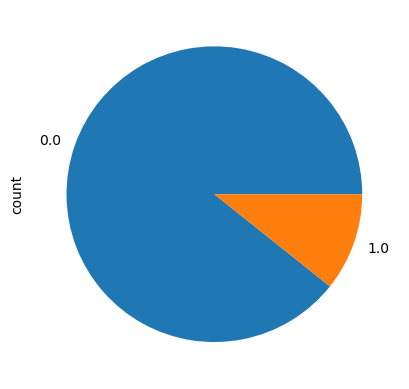

In [328]:
df['TARGET'].value_counts().plot(kind='pie')
# Imbalanced dataset

## Finding the most prominent features by correlation matrix and Sequential Feature Selector

<Axes: >

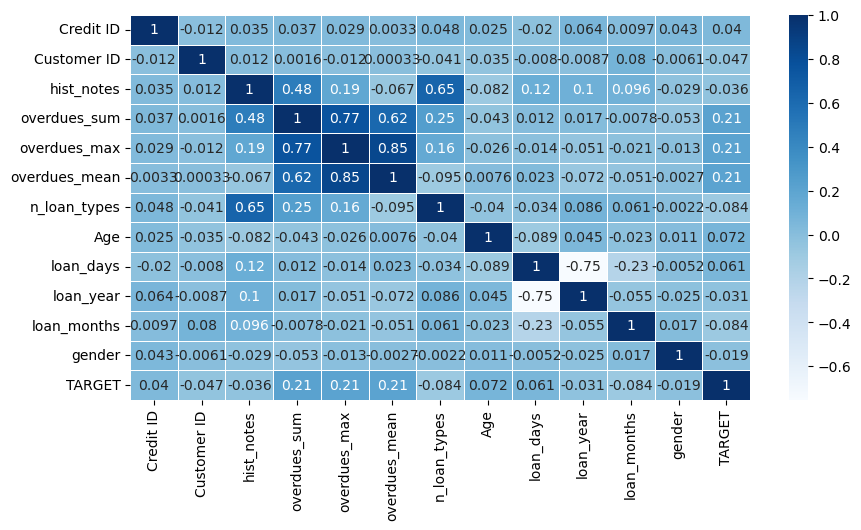

In [329]:
#! Я бы не стал рассамтривать ID кредита и клиента как фичи. Эти поля определяются особенностями потроения базы данных, а не тем, какую информацию несут кредит и клиент.
# Корреляционная матрица, чтобы выявить признаки
correlation_matrix = numerical_df.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', linewidths=0.5)

Target коррелирует значительнее всего с overdues колонками

In [330]:
#SFS для выявления наиболее оптимальных features
SFS = SequentialFeatureSelector(estimator=LogisticRegression(), n_features_to_select=8, direction='backward')

In [335]:
X1=numerical_df.drop(['Credit ID','Customer ID','TARGET', 'loan_days'],  axis=1)
y1= numerical_df['TARGET']

In [336]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=101)

In [337]:
X_train1.isnull().sum()

hist_notes       0
overdues_sum     0
overdues_max     0
overdues_mean    0
n_loan_types     0
Age              0
loan_year        0
loan_months      0
gender           0
dtype: int64

In [338]:
SFS.fit(X_train1, y_train1)

SequentialFeatureSelector(direction='backward', estimator=LogisticRegression(),
                          n_features_to_select=8)

In [339]:
sfs_features = X_train1.columns[SFS.get_support()].tolist()

In [237]:
sfs_features

['hist_notes',
 'overdues_max',
 'overdues_mean',
 'n_loan_types',
 'Age',
 'loan_days',
 'loan_year',
 'loan_months']

In [238]:
# Для сравнения features из коррелляции

In [341]:
numerical_df.corr(numeric_only=True)['TARGET'].sort_values(ascending=False)

TARGET           1.000000
overdues_sum     0.214278
overdues_max     0.210035
overdues_mean    0.209846
Age              0.072382
loan_days        0.061104
Credit ID        0.039644
gender          -0.019275
loan_year       -0.031285
hist_notes      -0.036473
Customer ID     -0.046583
loan_months     -0.083906
n_loan_types    -0.084030
Name: TARGET, dtype: float64

## Hyperparameters tuning and balancing target using SMOTE

In [342]:
selected_features = ['overdues_max','overdues_mean', 'overdues_sum',
 'n_loan_types', 'Age', 'gender', 'loan_year', 'loan_months']

In [343]:
X = numerical_df[selected_features]
y = numerical_df['TARGET']

In [344]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=101)

In [345]:
# Dealing with imbalance

In [346]:
smote = SMOTE(random_state=101)

In [347]:
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

In [348]:
# Objective functions for HP tuning by OPTUNA

In [349]:
def objective(trial):
    params = {
       "n_estimators": trial.suggest_int("lgb_n_estimators", 500, 3000, step=250),
        "learning_rate": trial.suggest_float("lgb_lr", 0.005, 0.2, log=True),
        "num_leaves": trial.suggest_int("lgb_num_leaves", 31, 255),
        "max_depth":trial.suggest_int("lgb_max_depth", -1, 24),
        "min_child_samples": trial.suggest_int("lgb_min_child_samples", 5, 200),
        "subsample": trial.suggest_float("lgb_subsample", 0.6, 1.0),
        "objective": "binary",
        "n_jobs": -1,
        "objective": "binary",
        "verbose": -1,}
    lgbc = LGBMClassifier(**params)
    lgbc.fit(X_train_bal, y_train_bal)
    val_preds = lgbc.predict_proba(X_test)[:, 1]
    auc_sc = roc_auc_score(y_test, val_preds)
    return auc_sc

Training Optuna

In [355]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)
print("Best accuracy:", study.best_trial.value)

[I 2025-08-23 22:45:50,148] A new study created in memory with name: no-name-6ae8297a-693d-4868-ba62-a86c9c0e110d
[I 2025-08-23 22:45:52,970] Trial 0 finished with value: 0.7029774872912128 and parameters: {'lgb_n_estimators': 2500, 'lgb_lr': 0.009295171721223593, 'lgb_num_leaves': 103, 'lgb_max_depth': 19, 'lgb_min_child_samples': 99, 'lgb_subsample': 0.8920142892465397}. Best is trial 0 with value: 0.7029774872912128.
[I 2025-08-23 22:45:53,528] Trial 1 finished with value: 0.6895424836601307 and parameters: {'lgb_n_estimators': 750, 'lgb_lr': 0.17303887475743213, 'lgb_num_leaves': 79, 'lgb_max_depth': 18, 'lgb_min_child_samples': 145, 'lgb_subsample': 0.6183021530890825}. Best is trial 0 with value: 0.7029774872912128.
[I 2025-08-23 22:45:57,588] Trial 2 finished with value: 0.6706608569353667 and parameters: {'lgb_n_estimators': 750, 'lgb_lr': 0.008119916055867898, 'lgb_num_leaves': 135, 'lgb_max_depth': 15, 'lgb_min_child_samples': 18, 'lgb_subsample': 0.9654084114307134}. Best is

Number of finished trials: 100
Best trial: {'lgb_n_estimators': 500, 'lgb_lr': 0.1987767475519095, 'lgb_num_leaves': 173, 'lgb_max_depth': 1, 'lgb_min_child_samples': 57, 'lgb_subsample': 0.8132071180864728}
Best accuracy: 0.7645243282498184


## Checking model with the best HPs on ROC-AUC, Optuna

In [364]:
best_params = study.best_params.copy()
best_params.update(dict(objective="binary", n_jobs=-1, random_state=101, verbose=-1))
best_lgbmc = LGBMClassifier(**best_params)

In [365]:
best_lgbmc.fit(X_train, y_train)

LGBMClassifier(lgb_lr=0.1987767475519095, lgb_max_depth=1,
               lgb_min_child_samples=57, lgb_n_estimators=500,
               lgb_num_leaves=173, lgb_subsample=0.8132071180864728, n_jobs=-1,
               objective='binary', random_state=101, verbose=-1)

ROC-AUC, Gini index results

In [366]:
probability = best_lgbmc.predict_proba(X_test)[:, 1]      # or X_te from the snippet above
auc = roc_auc_score(y_test, probability)          # or y_te
gini  = 2*auc - 1
print(f"ROC-AUC: {auc.round(2)} и Gini: {gini.round(2)}")

ROC-AUC: 0.78 и Gini: 0.55


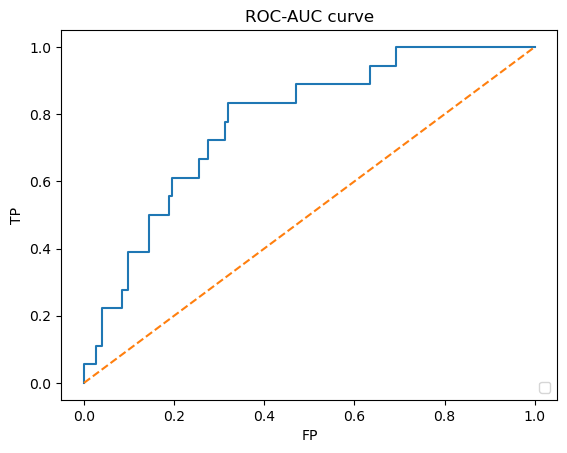

In [368]:
# 1) Get probabilities for the positive class
probabilities = best_lgbmc.predict_proba(X_test)[:, 1]   # LightGBM/XGBoost/RandomForest

# 2) Compute ROC points + AUC
FP, TP, thres = roc_curve(y_test, probabilities)
AUC_LINE = roc_auc_score(y_test, probabilities)
gini = 2*AUC_LINE - 1

# 3) Plot
plt.figure()
plt.plot(FP, TP)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('FP')
plt.ylabel('TP')
plt.title('ROC-AUC curve')
plt.legend(loc='lower right')
plt.show()